---
title: "Bivariate EM"
author: "Vivek Sivaramakrishnan"
format:
  html:
    theme: theme.scss
    toc: true
    html-math-method: katex
---

Colab: [Click here!](https://colab.research.google.com/drive/18AsBx3o0nJLi0aty50zReV6lTK33K3Dr?usp=sharing){target="_blank"}

--2023-11-09 15:07:06--  https://raw.githubusercontent.com/data-8/materials-su19/master/materials/su19/hw/hw02/old_faithful.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2270 (2.2K) [text/plain]
Saving to: ‘old_faithful.csv.5’

old_faithful.csv.5  100%[===================>]   2.22K  --.-KB/s    in 0s      

2023-11-09 15:07:06 (38.5 MB/s) - ‘old_faithful.csv.5’ saved [2270/2270]



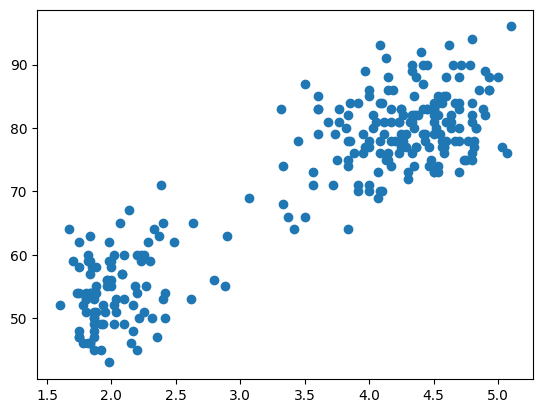

In [ ]:
!wget https://raw.githubusercontent.com/data-8/materials-su19/master/materials/su19/hw/hw02/old_faithful.csv

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
import pandas as pd
from matplotlib import mlab

X = pd.read_csv('old_faithful.csv')[['eruptions', 'waiting']].to_numpy()
plt.scatter(X[:, 0], X[:, 1])

M, N = np.mgrid[min(X[:, 0])-1:max(X[:, 0])+1:0.01, min(X[:, 1])-1:max(X[:, 1])+1:0.01]
grid = np.dstack((M, N))

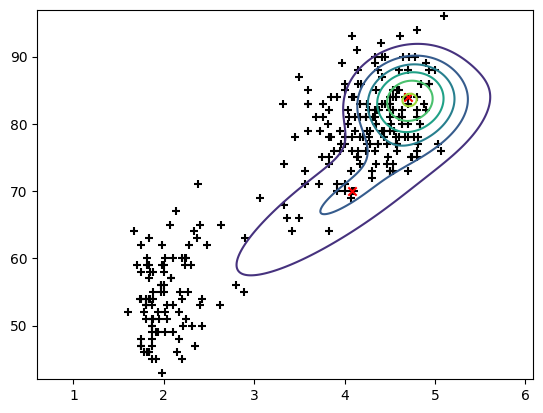

In [ ]:
K = 2

rng = np.random.default_rng()
centres = X[rng.integers(low=0, high=len(X), size=K)]
l = np.array([(lambda i: [int(i==j) for j in range(K)])(np.argmin([np.linalg.norm(p-centre) for centre in centres])) for p in X])
pi = l.sum(axis=0)/l.sum()

cov = []
for i in range(K):
  cov.append(np.cov(X.T, ddof=0, aweights=l[:, i]))
cov = np.array(cov)

def plot():

  plt.scatter(X[:, 0], X[:, 1], color='black', marker='+')
  plt.scatter(centres[:, 0], centres[:, 1], color='red', marker='x')

  probability_grid = np.zeros(grid.shape[:2])
  for i in range(K):
    probability_grid += pi[i] * multivariate_normal(centres[i], cov[i]).pdf(grid)

  plt.contour(M, N, probability_grid)
  plt.show()

plot()

In [ ]:
# Expectation Step
def Exp(l):
  pi = l.sum(axis=0)/l.sum()
  centres, cov = [], []
  for i in range(K):
    centres.append(np.dot(l[:, i], X)/l[:, i].sum())
    cov.append(np.cov(X.T, ddof=0, aweights=l[:, i]))

  return pi, np.array(centres), np.array(cov)

# Maximization step
def Max(pi, centres, cov):
  l = []
  for i in X:
    p = np.array([pi[k] * multivariate_normal.pdf(i, mean=centres[k], cov=cov[k]) for k in range(K)])
    p = p/p.sum()
    l.append(p)

  return np.array(l)

# Convergence criterion
norm_theta = lambda pi, centres, cov: np.linalg.norm(np.r_[pi, centres.reshape(-1), cov.reshape(-1)])

In [ ]:
from IPython.display import HTML
from matplotlib import animation

prev_norm = norm_theta(pi, centres, cov)

fig, ax = plt.subplots()
artists = []

while True:
  l = Max(pi, centres, cov)
  pi, centres, cov = Exp(l)

  frame = []
  frame.append(ax.scatter(X[:, 0], X[:, 1], color='black', marker='+'))
  frame.append(ax.scatter(centres[:, 0], centres[:, 1], color='red', marker='x'))

  probability_grid = np.zeros(grid.shape[:2])
  for i in range(K):
    probability_grid += pi[i] * multivariate_normal(centres[i], cov[i]).pdf(grid)

  frame += list(ax.contour(M, N, probability_grid).collections)
  artists.append(frame)

  curr_norm = norm_theta(pi, centres, cov)

  if abs(curr_norm-prev_norm) < 1:
    break
  else:
    prev_norm = curr_norm

plt.close()
anim = animation.ArtistAnimation(fig, artists, interval=200, repeat=False, blit=False);
HTML(anim.to_jshtml())